# Whole city count prediction 

In [1]:
from utils.plots import plot, displot
from seaborn import distplot
import matplotlib.pyplot as plt
from models.baseline_models import historic_average

import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, \
    compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler

from pprint import pprint
import logging

from matplotlib import rcParams
from utils.forecasting import compare_time_series_metrics

from utils.utils import load_total_counts, to_title, set_system_seed
from utils.data_processing import normalize_df
from utils.plots import plot, plot_df, plot_time_signals

from utils.forecasting import forecast_metrics

from models.sequence_models import train_epoch_for_sequence_model, evaluate_sequence_model
import plotly.graph_objects as go

os.environ['NUMEXPR_MAX_THREADS'] = str(os.cpu_count())
rcParams["font.family"] = "STIXGeneral"

In [2]:
from datasets.sequence_dataset import SequenceDataLoaders
from models.rnn_models import GRUFNN

In [3]:
data_sub_paths = [i for i in get_data_sub_paths() if i.startswith('Totals')]
data_sub_paths

['Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_LON-87.821_-87.525']

In [4]:
data_sub_path = data_sub_paths[0]
save_folder = f"./data/processed/{data_sub_path}/plots/"
os.makedirs(save_folder, exist_ok=True)
FREQ = data_sub_path.lstrip('Totals_T').split('_')[0]
time_steps_per_day = 24/int(FREQ[:-1])

freq_title = {
    "24H":"Daily",
    "1H": "Hourly",
    "168H":"Weekly",
}.get(FREQ, "Hourly")
print(f"Using: {freq_title} ({FREQ})")

Using: Daily (24H)


In [5]:
df = load_total_counts(folder_name=data_sub_path)
df['TOTAL'] = df.sum(axis=1)
df = df.reindex(columns=np.roll(df.columns, 1))
df.columns = to_title(df.columns)
display(df)

Total  Theft  Battery  Criminal Damage  Narcotics  Assault  \
2001-01-01   1253    400      292              232         96       70   
2001-01-02    884    218      142              118        175       65   
2001-01-03    910    222      163              136        133       79   
2001-01-04    939    241      172              132        142       57   
2001-01-05   1020    260      177              138        185       67   
...           ...    ...      ...              ...        ...      ...   
2018-12-27    469    157       90               65         26       43   
2018-12-28    547    177      114               62         53       46   
2018-12-29    535    132      139               83         38       50   
2018-12-30    530    133      134               83         32       47   
2018-12-31    506    153      105               93         21       41   

            Burglary  Motor Vehicle Theft  Robbery  
2001-01-01        65                   58       40  
2001-01-02        68                   64       34  
2001-01-03        57                   69       51  
2001-01-04        53                   87       55  
2001-01-05        55                   83       55  
...              ...                  ...      ...  
2018-12-27        33                   28       27  
2018-12-28        32                   25       38  
2018-12-29        35                   28       30  
2018-12-30        31                   32       38  
2018-12-31        29                   25       39  

[6574 rows x 9 columns]

In [6]:
# if torch.cuda.is_available():
#     print(torch.cuda.memory_summary())
# else:
#     raise Exception("CUDA is not available")

In [7]:
# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
set_system_seed(conf.seed)
conf.model_name = f"{freq_title} City Count" # "SimpleKangFNN" # "KangFNN"  # needs to be created
conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

# SET THE HYPER PARAMETERS
conf.shaper_top_k = -1
conf.use_classification = False
conf.train_set_first = True
conf.use_crime_types = False

2021-01-05T21:07:14 | root | INFO | =====================================BEGIN=====================================
2021-01-05T21:07:14 | root | INFO | Device: cuda:0


# Determine the total crime counts in the next time step

In [8]:
# total_t_range = df.index
# t_range= total_t_range[1:] # should be t_range of target date

# feature_names = list(df.columns)
# unscaled_total_crime_types = df#crimes[:,:-1].sum(2).sum(2)
# print(feature_names, len(feature_names), unscaled_total_crime_types.shape)

# assert len(total_t_range) == len(unscaled_total_crime_types)

# assert len(feature_names) == unscaled_total_crime_types.shape[1], \
#     f"feature_names:{len(feature_names)} != total_crime_types:{unscaled_total_crime_types.shape[1]}"

- `ST-ResNet`: closeness, period and trend
- `Season-decomp`: seasonal, trend, residual

### Anomaly Detection Plots

In [9]:
from utils.mutual_information_plots import subplot_mi_curves, plot_mi_curves
from utils.data_processing import to_percentile
from utils.rolling import rolling_norm, flag_anomalies, periodic_rolling_mean

plot_anomalies = False
if plot_anomalies:
    window =51
    period = {
        "24H":7,
        "1H": 24,
        "168H":1,
    }.get(FREQ, 1)
    thresh = 3
    period = 1

    for col in df.columns:
        a = df[col].values

        anoms = flag_anomalies(
            data=a, thresh=thresh, window=window, period=period, center=True, mode='reflect')

        ma = periodic_rolling_mean(data=a, window=window, period=period, center=True)
        normed = rolling_norm(data=a, window=window, period=period, center=True)

        go.Figure(
            data=[
                go.Scatter(x=df.index,y=a,opacity=.5,name=f'Counts'),
                go.Scatter(x=df.index[anoms],y=a[anoms],mode='markers',opacity=.5, name='Outliers'),
                go.Scatter(x=df.index,y=ma,opacity=.5,name=f'MA'),
            ],
            layout=dict(
                title_text=col,
                title_x=0.5,
                font=dict(family="STIXGeneral"),
                yaxis_title="Counts",
                xaxis_title="Date Time",
            ),
        ).show()

### Mutual Information Plots

In [10]:
# from utils.plots import subplots_df, plot_df
# from utils.mutual_information_plots import plot_mi_curves
plot_mi_curves = False
if plot_mi_curves:
    temporal_variables = {
        "1H":["Hour", "Day of Week", "Time of Month", "Time of Year"],
        "24H":["Day of Week", "Time of Month", "Time of Year"],
        "168H":["Time of Month", "Time of Year"],
    }.get(FREQ, ["Time of Month", "Time of Year"])


    max_offset = {
        "1H":168*2,
        "24H":365,
        "168H":54,
    }.get(FREQ)


    for i, name in enumerate(df.columns):
        a = df[name].values
        
        mutual_info_bins = 100
        print(f"optimal bins: {get_optimal_bins(a)}")
#         a = to_percentile(a)
        
        fig = subplot_mi_curves(
            a=a,
            t_range=df.index,
            max_offset=max_offset,
            norm=True,
            log_norm=False,
            bins=mutual_info_bins,
            month_divisions=4,
            year_divisions=4,
            temporal_variables=temporal_variables,
            title=f'{freq_title} {name} Mutual and Conditional Mutual Information',
            a_title=f'{freq_title} {name} City Wide Counts',
        )
        fig.write_image(f"{save_folder}{FREQ}_{name}_mi_plots.png".replace(' ','_'))
        fig.show()

In [11]:
# Normalize vectors
from utils.data_processing import DataFrameMinMaxScaler
scaler = DataFrameMinMaxScaler(minimum=0, maximum=1, axis=0)
total_df = scaler.fit_transform(df)

total_df = normalize_df(df)
display(total_df)

Total     Theft   Battery  Criminal Damage  Narcotics  \
2001-01-01  0.791209  0.858228  0.643646         0.613293   0.167266   
2001-01-02  0.501570  0.397468  0.229282         0.268882   0.309353   
2001-01-03  0.521978  0.407595  0.287293         0.323263   0.233813   
2001-01-04  0.544741  0.455696  0.312155         0.311178   0.250000   
2001-01-05  0.608320  0.503797  0.325967         0.329305   0.327338   
...              ...       ...       ...              ...        ...   
2018-12-27  0.175824  0.243038  0.085635         0.108761   0.041367   
2018-12-28  0.237049  0.293671  0.151934         0.099698   0.089928   
2018-12-29  0.227630  0.179747  0.220994         0.163142   0.062950   
2018-12-30  0.223705  0.182278  0.207182         0.163142   0.052158   
2018-12-31  0.204867  0.232911  0.127072         0.193353   0.032374   

             Assault  Burglary  Motor Vehicle Theft   Robbery  
2001-01-01  0.417323  0.477876             0.467290  0.428571  
2001-01-02  0.377953  0.504425             0.523364  0.350649  
2001-01-03  0.488189  0.407080             0.570093  0.571429  
2001-01-04  0.314961  0.371681             0.738318  0.623377  
2001-01-05  0.393701  0.389381             0.700935  0.623377  
...              ...       ...                  ...       ...  
2018-12-27  0.204724  0.194690             0.186916  0.259740  
2018-12-28  0.228346  0.185841             0.158879  0.402597  
2018-12-29  0.259843  0.212389             0.186916  0.298701  
2018-12-30  0.236220  0.176991             0.224299  0.402597  
2018-12-31  0.188976  0.159292             0.158879  0.415584  

[6574 rows x 9 columns]

In [12]:
# def get_period(series):
#     """
#     series: pandas series
#     """
#     max_lag = int(.1*len(series))
#     args = np.argsort([series.autocorr(i) for i in range(1,max_lag)])[::-1][:10] + 1
#     print(args)
#     return int(np.diff(args).mean())
    
# def autocorr(series):
#     max_lag = int(.1*len(series))
#     return np.array([series.autocorr(i) for i in range(1,max_lag)])
     
    
# arr = total_df.Total
# print(get_period(arr))

# plot(title='Total Crime',total=arr).show()

# auto_corr = autocorr(arr)
# auto_corr2 = autocorr(pd.Series(auto_corr))

# plot(title='Total Crime Auto-Correlation',auto_corr=auto_corr).show()
# plot(title='Total Crime Auto-Correlation Auto-Correlation',auto_corr2=auto_corr2).show()

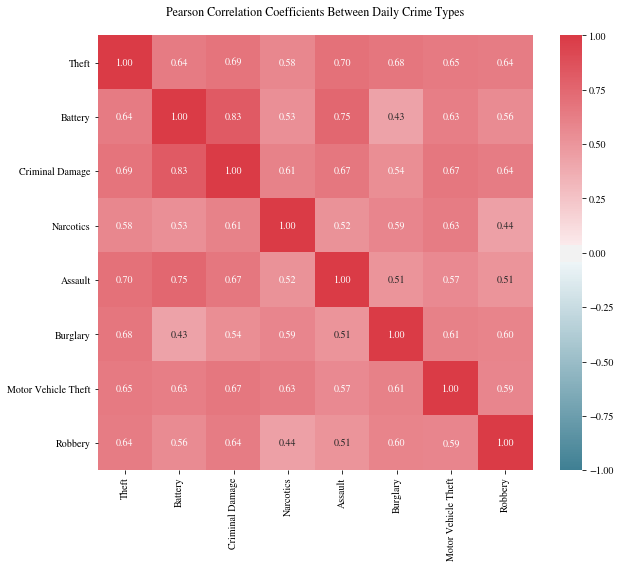

In [13]:
from utils.plots import plot_corr
corr = total_df.loc[:, total_df.columns != 'Total'].corr()
plot_corr(corr, title=f'Pearson Correlation Coefficients Between {freq_title} Crime Types\n')
plt.savefig(f"{save_folder}{FREQ}_corr_matrix.png")

In [14]:
t_range = total_df.index[1:] # should be equal to the target times
total_crime_types = total_df.values

In [15]:
time_vectors = encode_time_vectors(t_range, month_divisions=11, year_divisions=24, kind='sincos')  # kind='ohe')

k = int(time_steps_per_day*365)
tv, tr = time_vectors[:k], t_range[:k]

t_vec_names = {
    "1H":['$H_{sin}$', '$H_{cos}$', '$DoW_{sin}$', '$DoW_{cos}$',
          '$ToM_{sin}$', '$ToM_{cos}$', '$ToY_{sin}$', '$ToY_{cos}$', '$Wkd$'],
    "24H": ['$DoW_{sin}$','$DoW_{cos}$', '$ToM_{sin}$',
           '$ToM_{cos}$', '$ToY_{sin}$','$ToY_{cos}$', '$Wknd$'],
    "168H":['$ToM_{sin}$','$ToM_{cos}$', '$ToY_{sin}$','$ToY_{cos}$'],
}.get(FREQ)

fig = go.Figure(
    data=go.Heatmap(
        z=tv.T,
        y=t_vec_names,
        x=tr,
    ),
    layout=dict(
        title=f"Encoded Time Vectors on {freq_title} Level",
        title_x=0.5,
        xaxis_title="Date",
        yaxis_title="Encoded Vector Values",
        font=dict(family="STIXGeneral"),
    ),
)
fig.write_image(f"{save_folder}{FREQ}_time_vector_encoding.png")
fig.show()

### Setup Data Loaders 

In [16]:
# conf.seq_len = 60 # int(14*time_steps_per_day) + 1
conf.seq_len = {
    "24H": 90,
    "1H": 168,
    "168H": 52,
}.get(FREQ, 60)

conf.batch_size = 128

logging.info(f"Using sequence length: {conf.seq_len}")

input_data= total_crime_types[:-1] 

predict_only_total = True
if predict_only_total:
    target_data = total_crime_types[1:, 0:1] 
else:
    target_data = total_crime_types[1:]

assert len(input_data) == len(time_vectors), \
    f"len(input_data) != len(time_vectors), {len(input_data)},{len(time_vectors)}"

use_time_vectors = True
if use_time_vectors:
    logging.info("using time vectors in input")
    input_data = np.concatenate([input_data,time_vectors],axis=1)
else:
    logging.info("NOT using time vectors in input")


input_size = input_data.shape[-1]
output_size = target_data.shape[-1]

assert len(input_data) == len(t_range)

test_size = {
    "24H":365,
    "H": 8760,
    "1H":8760,
    "1W":52,
    "168H":52,
}.get(FREQ)

tst_ratio = 0.25 # test_size/len(input_data)

loaders = SequenceDataLoaders(
    input_data=input_data,
    target_data=target_data,
    t_range=t_range,
    batch_size=conf.batch_size,
    seq_len=conf.seq_len,
    shuffle=conf.shuffle,
    num_workers=0,
    val_ratio=0.5,
    tst_ratio=tst_ratio,
)

input_data.shape, target_data.shape

2021-01-05T21:07:23 | root | INFO | Using sequence length: 90
2021-01-05T21:07:23 | root | INFO | using time vectors in input


((6573, 16), (6573, 1))

### Hyper-parameter Optimisation 

[INFO 01-05 21:09:33] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 01-05 21:09:33] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 01-05 21:09:33] ax.service.managed_loop: Running optimization trial 1...


2021-01-05T21:09:33 | root | INFO | Set system seed to 1609873773
2021-01-05T21:09:33 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:09:33 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.00032458286016763267,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

[INFO 01-05 21:10:19] ax.service.managed_loop: Running optimization trial 2...


2021-01-05T21:10:19 | root | INFO | Set system seed to 1609873819
2021-01-05T21:10:19 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:10:19 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 1.4987389324676853e-05,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

[INFO 01-05 21:10:43] ax.service.managed_loop: Running optimization trial 3...


2021-01-05T21:10:43 | root | INFO | Set system seed to 1609873843
2021-01-05T21:10:43 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:10:43 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 5.9047493262428375e-06,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

[INFO 01-05 21:11:12] ax.service.managed_loop: Running optimization trial 4...


2021-01-05T21:11:12 | root | INFO | Set system seed to 1609873872
2021-01-05T21:11:12 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:11:12 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.00025322692721655744,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

[INFO 01-05 21:12:40] ax.service.managed_loop: Running optimization trial 5...


2021-01-05T21:12:40 | root | INFO | Set system seed to 1609873960
2021-01-05T21:12:40 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:12:40 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 2.614048084537795e-06,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:13:27] ax.service.managed_loop: Running optimization trial 6...


2021-01-05T21:13:27 | root | INFO | Set system seed to 1609874007
2021-01-05T21:13:27 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:13:27 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0011403744461934398,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:14:00] ax.service.managed_loop: Running optimization trial 7...


2021-01-05T21:14:00 | root | INFO | Set system seed to 1609874040
2021-01-05T21:14:00 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:14:00 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 3.81059843125133e-05,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scale

[INFO 01-05 21:14:19] ax.service.managed_loop: Running optimization trial 8...


2021-01-05T21:14:19 | root | INFO | Set system seed to 1609874059
2021-01-05T21:14:19 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:14:19 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0005105179946420073,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:15:17] ax.service.managed_loop: Running optimization trial 9...


2021-01-05T21:15:17 | root | INFO | Set system seed to 1609874117
2021-01-05T21:15:17 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:15:17 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0008647057818008371,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:16:00] ax.service.managed_loop: Running optimization trial 10...


2021-01-05T21:16:00 | root | INFO | Set system seed to 1609874160
2021-01-05T21:16:00 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:16:00 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0010516817900936377,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:16:38] ax.service.managed_loop: Running optimization trial 11...


2021-01-05T21:16:38 | root | INFO | Set system seed to 1609874198
2021-01-05T21:16:38 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:16:38 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.01,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scale_axis': 1,
 'see

[INFO 01-05 21:17:02] ax.service.managed_loop: Running optimization trial 12...


2021-01-05T21:17:02 | root | INFO | Set system seed to 1609874222
2021-01-05T21:17:02 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:17:02 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0005056346340327435,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:17:57] ax.service.managed_loop: Running optimization trial 13...


2021-01-05T21:17:57 | root | INFO | Set system seed to 1609874277
2021-01-05T21:17:57 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:17:57 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.00195303141493488,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scale_

[INFO 01-05 21:18:30] ax.service.managed_loop: Running optimization trial 14...


2021-01-05T21:18:31 | root | INFO | Set system seed to 1609874311
2021-01-05T21:18:31 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:18:31 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0007089403768575973,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:19:21] ax.service.managed_loop: Running optimization trial 15...


2021-01-05T21:19:21 | root | INFO | Set system seed to 1609874361
2021-01-05T21:19:21 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:19:21 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0010542255596704183,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:20:02] ax.service.managed_loop: Running optimization trial 16...


2021-01-05T21:20:02 | root | INFO | Set system seed to 1609874402
2021-01-05T21:20:02 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:20:02 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0015213170005533045,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:20:20] ax.service.managed_loop: Running optimization trial 17...


2021-01-05T21:20:21 | root | INFO | Set system seed to 1609874421
2021-01-05T21:20:21 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:20:21 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0009375608237377725,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:21:03] ax.service.managed_loop: Running optimization trial 18...


2021-01-05T21:21:03 | root | INFO | Set system seed to 1609874463
2021-01-05T21:21:03 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:21:03 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.0006554061260764393,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'scal

[INFO 01-05 21:21:45] ax.service.managed_loop: Running optimization trial 19...


2021-01-05T21:21:46 | root | INFO | Set system seed to 1609874506
2021-01-05T21:21:46 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:21:46 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.00034557818474912684,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

[INFO 01-05 21:23:14] ax.service.managed_loop: Running optimization trial 20...


2021-01-05T21:23:15 | root | INFO | Set system seed to 1609874595
2021-01-05T21:23:15 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T21:23:15 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'best_val',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.00040594160036870163,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 30,
 'resume': False,
 'sca

arm_name metric_name      mean  sem  trial_index
0       0_0        MASE  1.273172  0.0            0
1       1_0        MASE  1.970659  0.0            1
2       2_0        MASE  1.915900  0.0            2
3       3_0        MASE  1.288301  0.0            3
4       4_0        MASE  1.950480  0.0            4
5       5_0        MASE  1.253035  0.0            5
6       6_0        MASE  1.997288  0.0            6
7       7_0        MASE  1.233846  0.0            7
8       8_0        MASE  1.224675  0.0            8
9       9_0        MASE  1.217982  0.0            9
10     10_0        MASE  1.850959  0.0           10
11     11_0        MASE  1.311156  0.0           11
12     12_0        MASE  1.314535  0.0           12
13     13_0        MASE  1.260180  0.0           13
14     14_0        MASE  1.243020  0.0           14
15     15_0        MASE  3.949455  0.0           15
16     16_0        MASE  1.249838  0.0           16
17     17_0        MASE  1.180609  0.0           17
18     18_0        MASE  1.242780  0.0           18
19     19_0        MASE  1.302017  0.0           19

{'lr': 0.0006554061260764393, 'weight_decay': 9.643537831080278e-05}


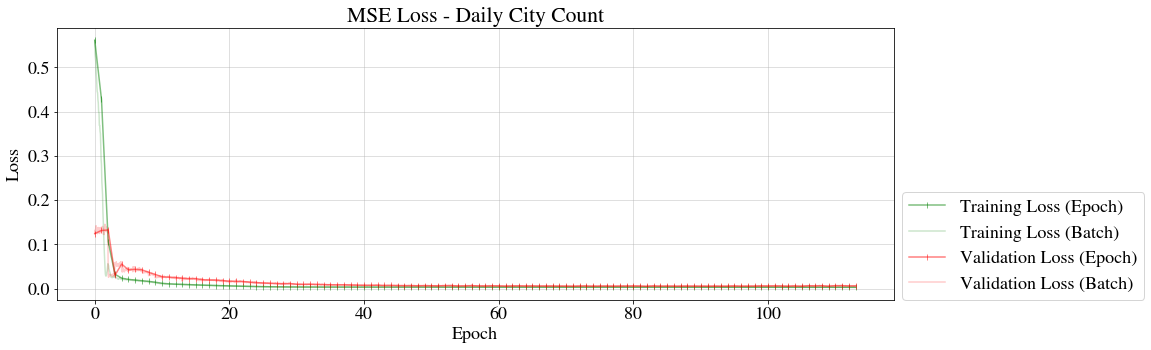

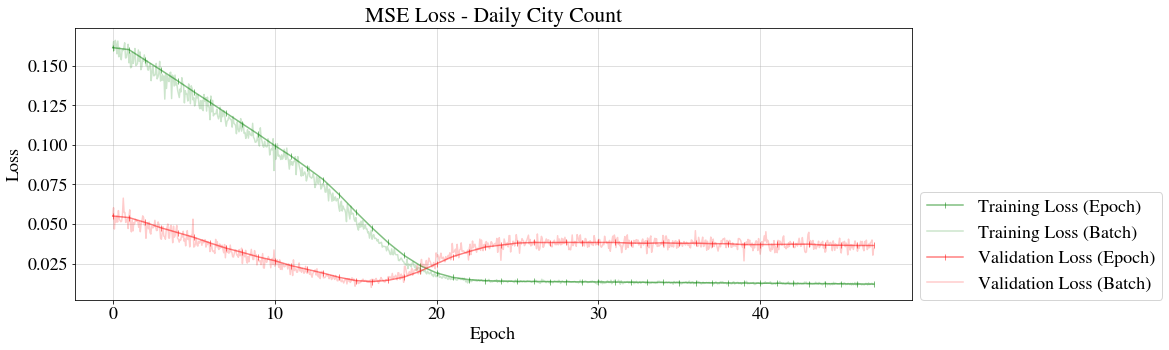

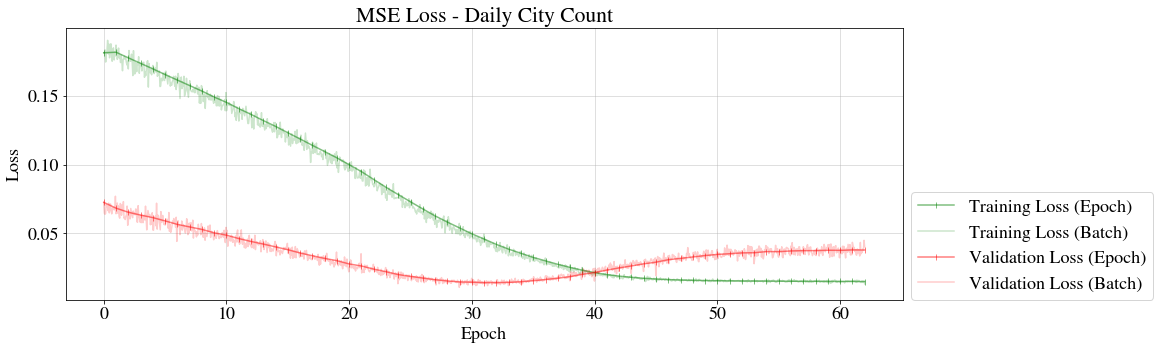

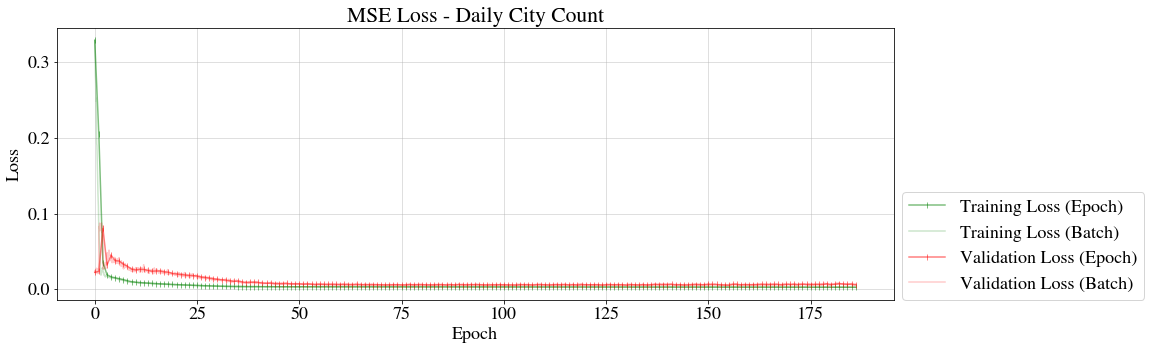

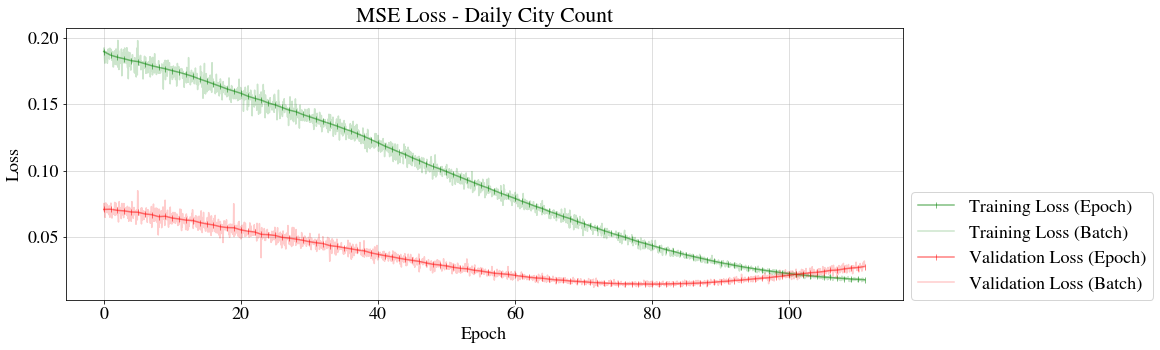

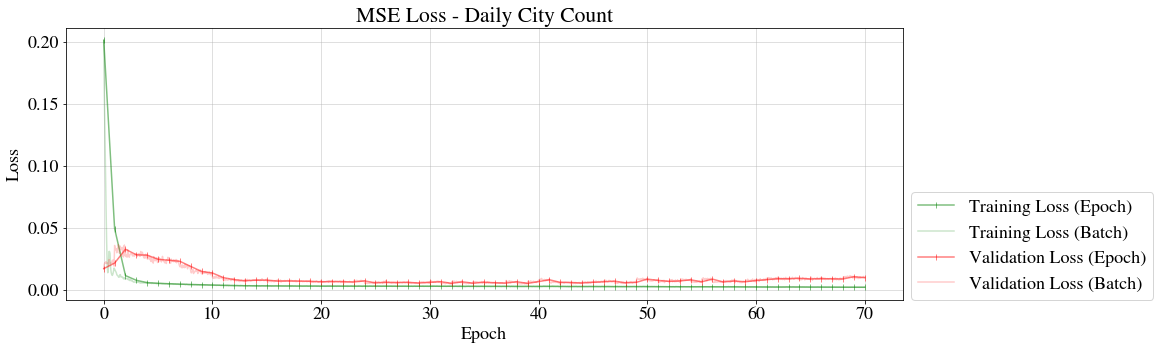

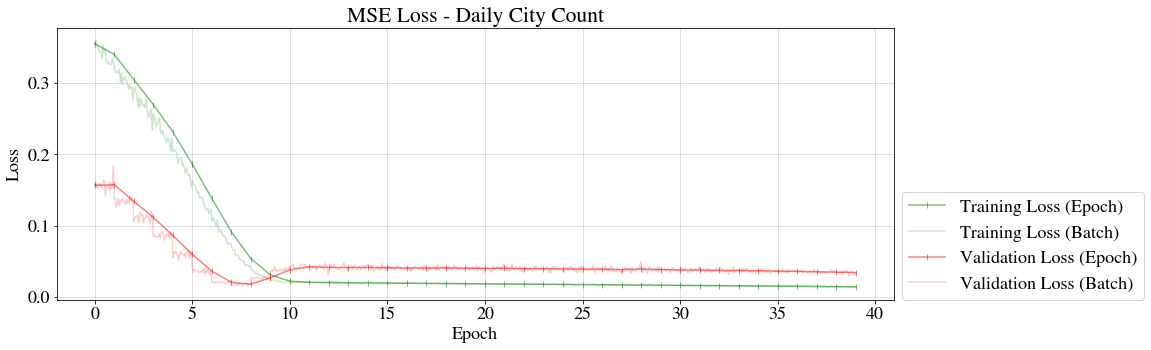

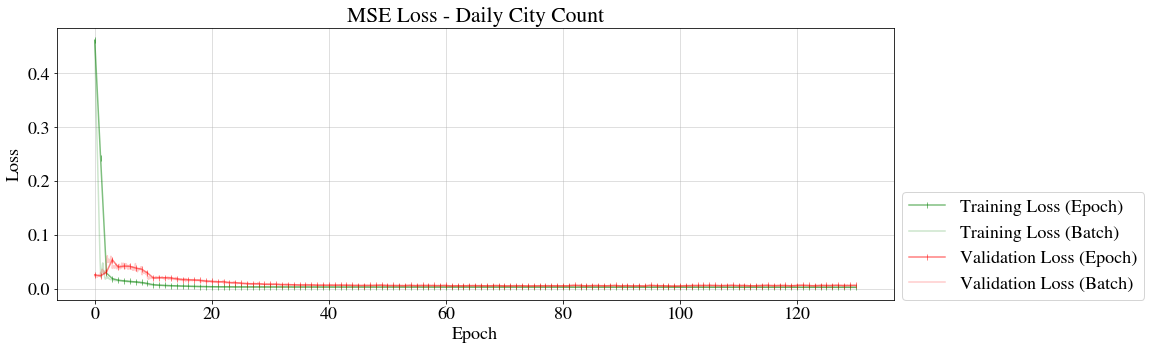

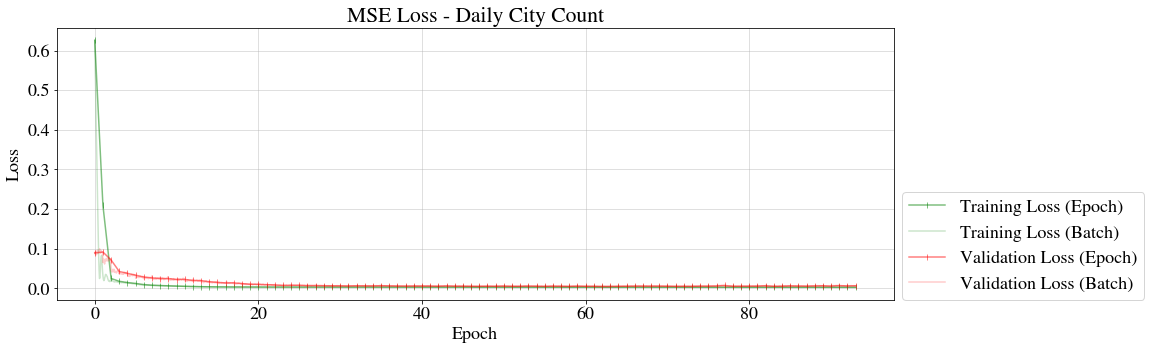

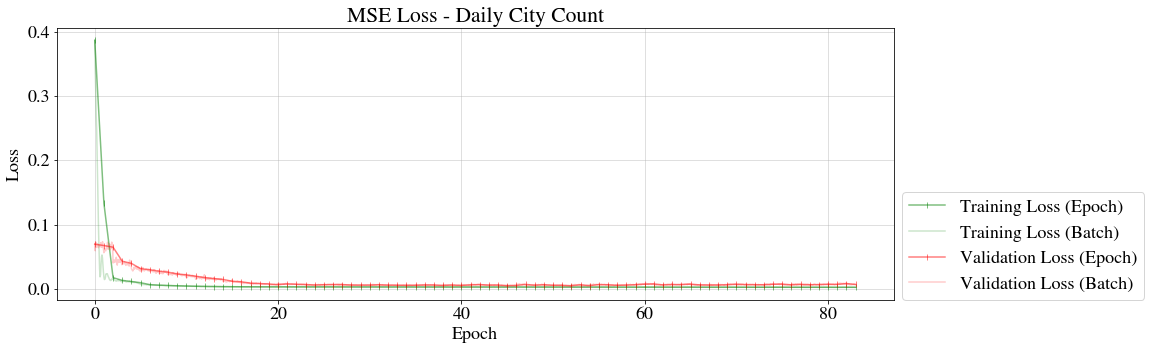

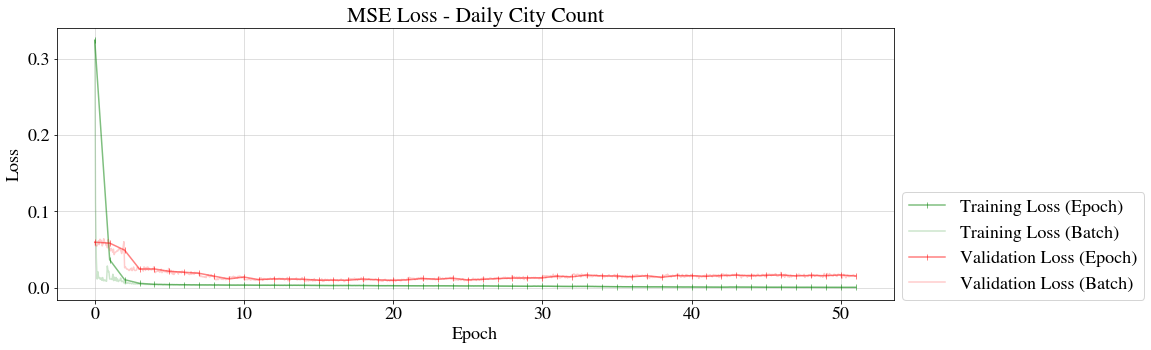

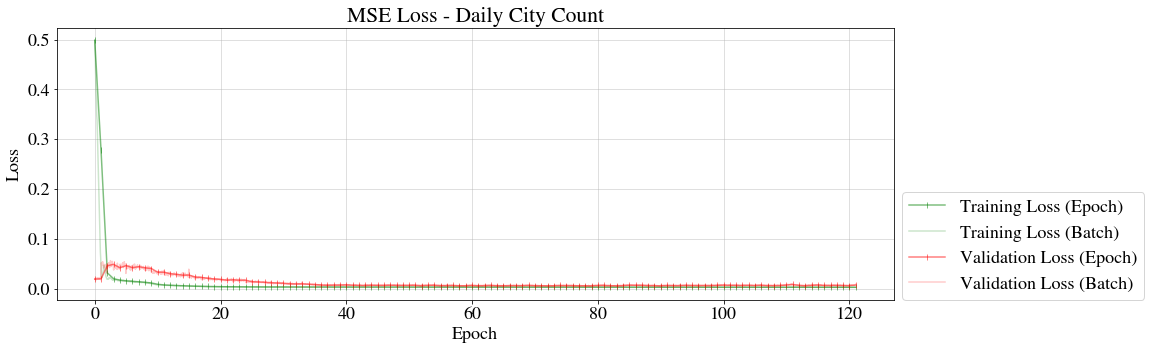

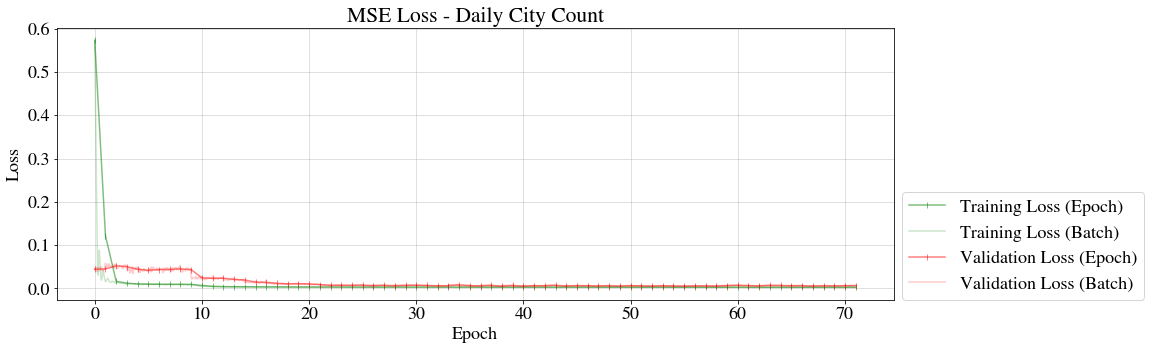

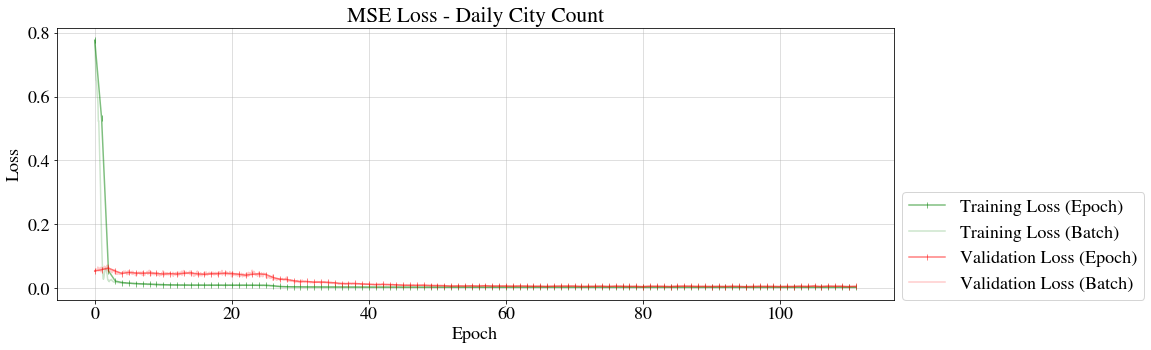

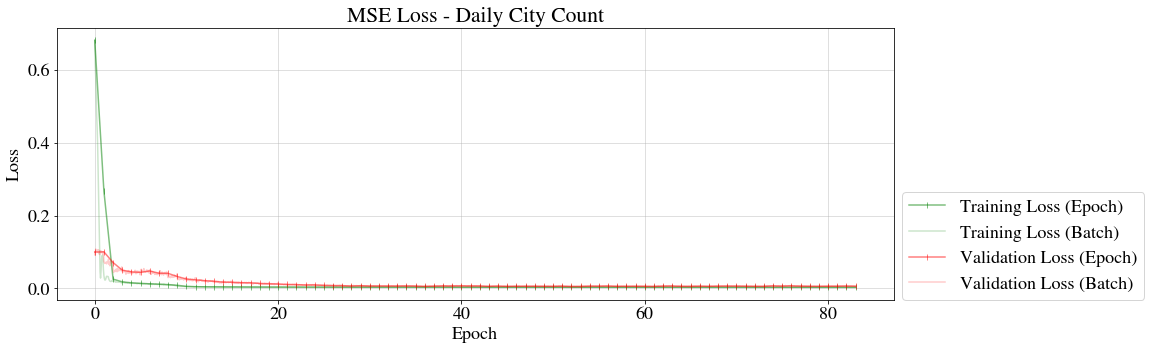

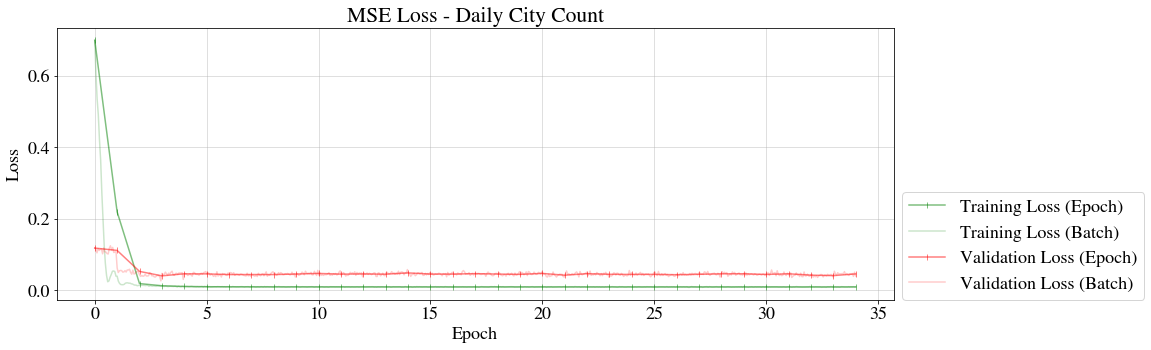

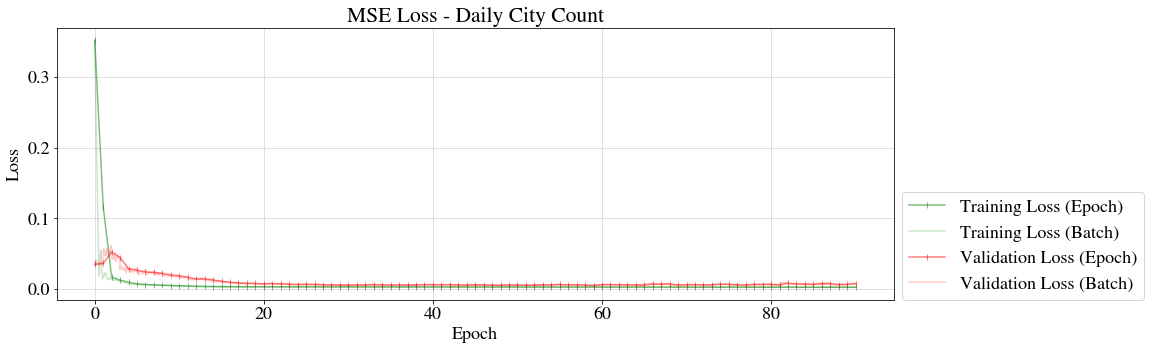

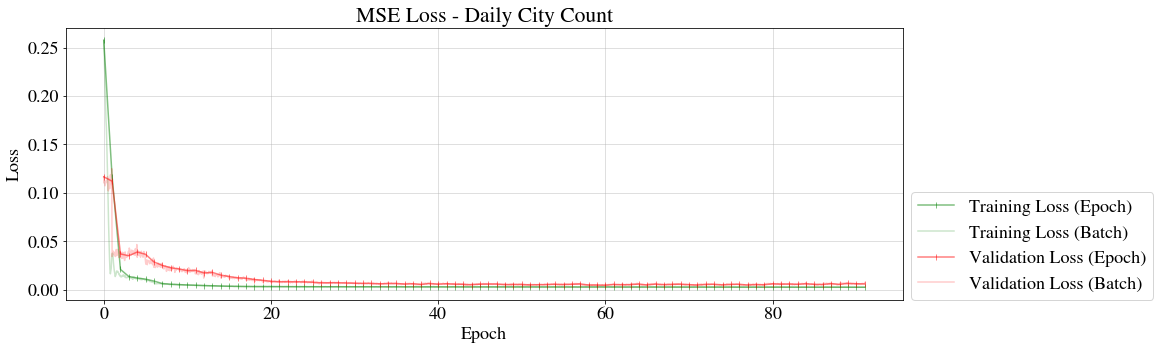

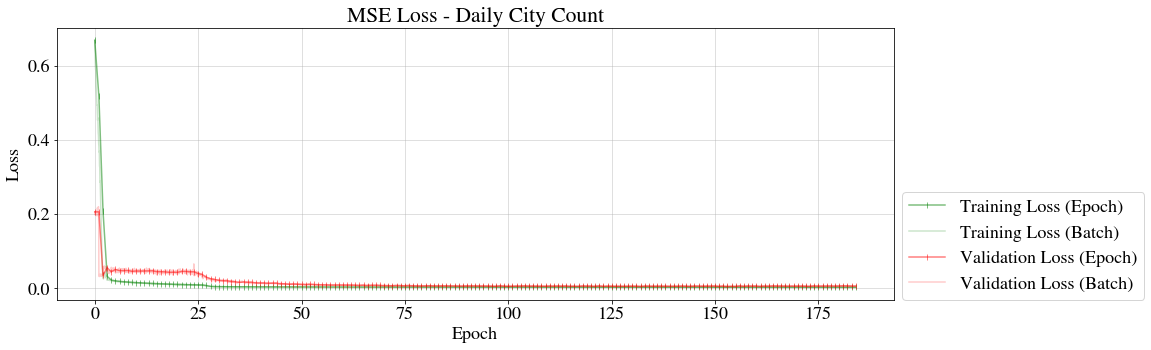

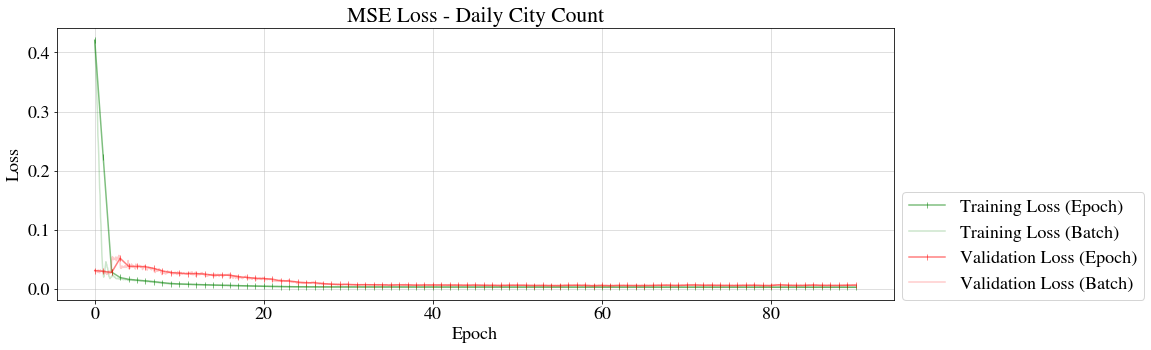

In [18]:
def train_evaluate_hyper(hyper_parameters):
    # hyper param setup
    hidden_size = hyper_parameters.get('hidden_size',50)
    num_layers = hyper_parameters.get('num_layers',5)
    conf.weight_decay = hyper_parameters.get('weight_decay', 1e-4)  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
    conf.lr = hyper_parameters.get('lr', 1e-3)
    
    conf.resume = False
    conf.early_stopping = True
    conf.patience = 30
    conf.min_epochs = 1
    conf.max_epochs = 500
    
    
    set_system_seed(int(time())) # should be reset with each model instatiation
    
    # model setup
    model = GRUFNN(
        input_size=input_size,
        hidden_size0=hidden_size, 
        hidden_size1=hidden_size//2, 
        output_size=output_size,
        num_layers=num_layers,
    ).to(conf.device)

    criterion = nn.MSELoss()
    optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

    # training
    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
        model=model,
        optimiser=optimiser,
        loaders=loaders,
        train_epoch_fn=train_epoch_for_sequence_model,
        loss_fn=criterion,
        conf=conf,
        verbose=False,
    )
    
    # load the saved best validation model
    # Load latest or best validation model
    conf.checkpoint = "best_val"
    log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")
    log.info(f"Loading model from {conf.model_path}")
    model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth", map_location=conf.device.type)
    model.load_state_dict(model_state_dict)
    
    # evaluation
    val_y_true, val_y_score = evaluate_sequence_model(model, loaders.validation_loader, conf)
    
    return forecast_metrics(y_true=val_y_true, y_score=val_y_score)['MASE']

    
# Hyper Opt Training

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

# PARAM_CLASSES = ["range", "choice", "fixed"]
# PARAM_TYPES = {"int": int, "float": float, "bool": bool, "str": str}
# potential parameters
hyper_params = [
    {"name": "lr", "type": "range", "bounds": [1e-6, 1e-2], "log_scale": True},
    {"name": "weight_decay", "type": "range", "bounds": [1e-8, 1e-2], "log_scale": True},    
#     {"name": "num_layers", "type": "choice", "values": [1,2,4,8]},
]

best_parameters, values, experiment, model = optimize(
    parameters=hyper_params,
    evaluation_function=train_evaluate_hyper,
    objective_name='MASE',
    minimize=True, # change when the objective is a loss
    total_trials=20,
#     random_seed=1, # optional
)

experiment_data = experiment.fetch_data()
display(experiment_data.df)
print(best_parameters)

In [19]:
init_notebook_plotting()
render(plot_contour(model=model, param_x='lr', param_y='weight_decay', metric_name='MASE'))

### Setup Model

In [17]:
conf.seed = 1607355910 # int(time())

hidden_size = 16
num_layers = 2

set_system_seed(conf.seed) # should be reset with each model instatiation
model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=output_size,
    num_layers=num_layers,
).to(conf.device)

# model = nn.Sequential(
#     nn.Linear(in_features=input_size,out_features=hidden_size),
#     nn.RReLU(0.01,0.3),
#     nn.Linear(in_features=hidden_size,out_features=1),
# )

criterion = nn.MSELoss()

conf.weight_decay = 1e-6  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
conf.lr = 1e-3

optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

# h0 = torch.randn(num_layers, batch_size, hidden_size)  # (num_layers * num_directions, batch, hidden_size)
with torch.no_grad():
    idx, inp, trg = next(iter(loaders.test_loader))
    output = model(inp.to(conf.device)) #, h0)
    print(idx.size(), inp.size(), trg.size(), output.size())

2021-01-05T20:52:56 | root | INFO | Set system seed to 1607355910
torch.Size([128]) torch.Size([128, 90, 16]) torch.Size([128, 90, 1]) torch.Size([128, 90, 1])


2021-01-05T19:25:49 | root | INFO | 
 ====================== Training Daily City Count ====================== 

2021-01-05T19:25:49 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.001,
 'max_epochs': 500,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 100,
 'resume': False,
 'scale_axis': 1,
 'seed': 1607355910,
 'seq_len': 90,
 'shaper_threshold': 0,
 'shaper_t

2021-01-05T19:25:52 | root | INFO | 	Loss (Trn): 		0.00423634
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Trn): 	0.00423634
2021-01-05T19:25:52 | root | INFO | 	Loss (Val): 		0.01929524
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Val): 	0.01516660
2021-01-05T19:25:52 | root | INFO | 	Loss (Trn Val Dif): 	0.01505890

2021-01-05T19:25:52 | root | INFO | Epoch: 0019/0500
2021-01-05T19:25:52 | root | INFO | 	Loss (Trn): 		0.00415473
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Trn): 	0.00415473
2021-01-05T19:25:52 | root | INFO | 	Loss (Val): 		0.01872830
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Val): 	0.01516660
2021-01-05T19:25:52 | root | INFO | 	Loss (Trn Val Dif): 	0.01457356

2021-01-05T19:25:52 | root | INFO | Epoch: 0020/0500
2021-01-05T19:25:52 | root | INFO | 	Loss (Trn): 		0.00409038
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Trn): 	0.00409038
2021-01-05T19:25:52 | root | INFO | 	Loss (Val): 		0.01762142
2021-01-05T19:25:52 | root | INFO | 	Loss (Best Val)

2021-01-05T19:25:56 | root | INFO | 	Loss (Trn Val Dif): 	0.00628208

2021-01-05T19:25:56 | root | INFO | Epoch: 0040/0500
2021-01-05T19:25:56 | root | INFO | 	Loss (Trn): 		0.00330352
2021-01-05T19:25:56 | root | INFO | 	Loss (Best Trn): 	0.00330352
2021-01-05T19:25:56 | root | INFO | 	Loss (Val): 		0.00972655
2021-01-05T19:25:56 | root | INFO | 	Loss (Best Val): 	0.00960124
2021-01-05T19:25:56 | root | INFO | 	Loss (Trn Val Dif): 	0.00642303

2021-01-05T19:25:56 | root | INFO | Epoch: 0041/0500
2021-01-05T19:25:56 | root | INFO | 	Loss (Trn): 		0.00328809
2021-01-05T19:25:56 | root | INFO | 	Loss (Best Trn): 	0.00328809
2021-01-05T19:25:56 | root | INFO | 	Loss (Val): 		0.00924334
2021-01-05T19:25:56 | root | INFO | 	Loss (Best Val): 	0.00924334
2021-01-05T19:25:56 | root | INFO | 	Loss (Trn Val Dif): 	0.00595525

2021-01-05T19:25:56 | root | INFO | Epoch: 0042/0500
2021-01-05T19:25:56 | root | INFO | 	Loss (Trn): 		0.00328333
2021-01-05T19:25:56 | root | INFO | 	Loss (Best Trn): 	0.

2021-01-05T19:26:00 | root | INFO | 	Loss (Val): 		0.00678092
2021-01-05T19:26:00 | root | INFO | 	Loss (Best Val): 	0.00678092
2021-01-05T19:26:00 | root | INFO | 	Loss (Trn Val Dif): 	0.00366827

2021-01-05T19:26:00 | root | INFO | Epoch: 0062/0500
2021-01-05T19:26:00 | root | INFO | 	Loss (Trn): 		0.00310261
2021-01-05T19:26:00 | root | INFO | 	Loss (Best Trn): 	0.00310261
2021-01-05T19:26:00 | root | INFO | 	Loss (Val): 		0.00678009
2021-01-05T19:26:00 | root | INFO | 	Loss (Best Val): 	0.00678009
2021-01-05T19:26:00 | root | INFO | 	Loss (Trn Val Dif): 	0.00367748

2021-01-05T19:26:00 | root | INFO | Epoch: 0063/0500
2021-01-05T19:26:01 | root | INFO | 	Loss (Trn): 		0.00309884
2021-01-05T19:26:01 | root | INFO | 	Loss (Best Trn): 	0.00309884
2021-01-05T19:26:01 | root | INFO | 	Loss (Val): 		0.00672589
2021-01-05T19:26:01 | root | INFO | 	Loss (Best Val): 	0.00672589
2021-01-05T19:26:01 | root | INFO | 	Loss (Trn Val Dif): 	0.00362705

2021-01-05T19:26:01 | root | INFO | Epoch: 0

2021-01-05T19:26:04 | root | INFO | 	Loss (Trn): 		0.00299714
2021-01-05T19:26:04 | root | INFO | 	Loss (Best Trn): 	0.00299714
2021-01-05T19:26:04 | root | INFO | 	Loss (Val): 		0.00631431
2021-01-05T19:26:04 | root | INFO | 	Loss (Best Val): 	0.00623420
2021-01-05T19:26:04 | root | INFO | 	Loss (Trn Val Dif): 	0.00331717

2021-01-05T19:26:04 | root | INFO | Epoch: 0084/0500
2021-01-05T19:26:05 | root | INFO | 	Loss (Trn): 		0.00299452
2021-01-05T19:26:05 | root | INFO | 	Loss (Best Trn): 	0.00299452
2021-01-05T19:26:05 | root | INFO | 	Loss (Val): 		0.00612125
2021-01-05T19:26:05 | root | INFO | 	Loss (Best Val): 	0.00612125
2021-01-05T19:26:05 | root | INFO | 	Loss (Trn Val Dif): 	0.00312673

2021-01-05T19:26:05 | root | INFO | Epoch: 0085/0500
2021-01-05T19:26:05 | root | INFO | 	Loss (Trn): 		0.00298861
2021-01-05T19:26:05 | root | INFO | 	Loss (Best Trn): 	0.00298861
2021-01-05T19:26:05 | root | INFO | 	Loss (Val): 		0.00619123
2021-01-05T19:26:05 | root | INFO | 	Loss (Best Val)

2021-01-05T19:26:08 | root | INFO | 	Loss (Trn Val Dif): 	0.00323308

2021-01-05T19:26:08 | root | INFO | Epoch: 0105/0500
2021-01-05T19:26:09 | root | INFO | 	Loss (Trn): 		0.00290564
2021-01-05T19:26:09 | root | INFO | 	Loss (Best Trn): 	0.00290564
2021-01-05T19:26:09 | root | INFO | 	Loss (Val): 		0.00602632
2021-01-05T19:26:09 | root | INFO | 	Loss (Best Val): 	0.00602632
2021-01-05T19:26:09 | root | INFO | 	Loss (Trn Val Dif): 	0.00312068

2021-01-05T19:26:09 | root | INFO | Epoch: 0106/0500
2021-01-05T19:26:09 | root | INFO | 	Loss (Trn): 		0.00290811
2021-01-05T19:26:09 | root | INFO | 	Loss (Best Trn): 	0.00290564
2021-01-05T19:26:09 | root | INFO | 	Loss (Val): 		0.00661520
2021-01-05T19:26:09 | root | INFO | 	Loss (Best Val): 	0.00602632
2021-01-05T19:26:09 | root | INFO | 	Loss (Trn Val Dif): 	0.00370709

2021-01-05T19:26:09 | root | INFO | Epoch: 0107/0500
2021-01-05T19:26:09 | root | INFO | 	Loss (Trn): 		0.00290221
2021-01-05T19:26:09 | root | INFO | 	Loss (Best Trn): 	0.

2021-01-05T19:26:13 | root | INFO | 	Loss (Val): 		0.00618247
2021-01-05T19:26:13 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:13 | root | INFO | 	Loss (Trn Val Dif): 	0.00335870

2021-01-05T19:26:13 | root | INFO | Epoch: 0127/0500
2021-01-05T19:26:13 | root | INFO | 	Loss (Trn): 		0.00283004
2021-01-05T19:26:13 | root | INFO | 	Loss (Best Trn): 	0.00282378
2021-01-05T19:26:13 | root | INFO | 	Loss (Val): 		0.00651234
2021-01-05T19:26:13 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:13 | root | INFO | 	Loss (Trn Val Dif): 	0.00368229

2021-01-05T19:26:13 | root | INFO | Epoch: 0128/0500
2021-01-05T19:26:13 | root | INFO | 	Loss (Trn): 		0.00281877
2021-01-05T19:26:13 | root | INFO | 	Loss (Best Trn): 	0.00281877
2021-01-05T19:26:13 | root | INFO | 	Loss (Val): 		0.00640390
2021-01-05T19:26:13 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:13 | root | INFO | 	Loss (Trn Val Dif): 	0.00358513

2021-01-05T19:26:13 | root | INFO | Epoch: 0

2021-01-05T19:26:17 | root | INFO | 	Loss (Trn): 		0.00275875
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Trn): 	0.00275875
2021-01-05T19:26:17 | root | INFO | 	Loss (Val): 		0.00661548
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:17 | root | INFO | 	Loss (Trn Val Dif): 	0.00385673

2021-01-05T19:26:17 | root | INFO | Epoch: 0149/0500
2021-01-05T19:26:17 | root | INFO | 	Loss (Trn): 		0.00275845
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Trn): 	0.00275845
2021-01-05T19:26:17 | root | INFO | 	Loss (Val): 		0.00675169
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:17 | root | INFO | 	Loss (Trn Val Dif): 	0.00399324

2021-01-05T19:26:17 | root | INFO | Epoch: 0150/0500
2021-01-05T19:26:17 | root | INFO | 	Loss (Trn): 		0.00275360
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Trn): 	0.00275360
2021-01-05T19:26:17 | root | INFO | 	Loss (Val): 		0.00679429
2021-01-05T19:26:17 | root | INFO | 	Loss (Best Val)

2021-01-05T19:26:21 | root | INFO | 	Loss (Trn Val Dif): 	0.00445644

2021-01-05T19:26:21 | root | INFO | Epoch: 0170/0500
2021-01-05T19:26:21 | root | INFO | 	Loss (Trn): 		0.00269035
2021-01-05T19:26:21 | root | INFO | 	Loss (Best Trn): 	0.00268399
2021-01-05T19:26:21 | root | INFO | 	Loss (Val): 		0.00674746
2021-01-05T19:26:21 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:21 | root | INFO | 	Loss (Trn Val Dif): 	0.00405711

2021-01-05T19:26:21 | root | INFO | Epoch: 0171/0500
2021-01-05T19:26:22 | root | INFO | 	Loss (Trn): 		0.00268670
2021-01-05T19:26:22 | root | INFO | 	Loss (Best Trn): 	0.00268399
2021-01-05T19:26:22 | root | INFO | 	Loss (Val): 		0.00714728
2021-01-05T19:26:22 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:22 | root | INFO | 	Loss (Trn Val Dif): 	0.00446058

2021-01-05T19:26:22 | root | INFO | Epoch: 0172/0500
2021-01-05T19:26:22 | root | INFO | 	Loss (Trn): 		0.00267705
2021-01-05T19:26:22 | root | INFO | 	Loss (Best Trn): 	0.

2021-01-05T19:26:25 | root | INFO | 	Loss (Val): 		0.00733356
2021-01-05T19:26:25 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:25 | root | INFO | 	Loss (Trn Val Dif): 	0.00472180

2021-01-05T19:26:25 | root | INFO | Epoch: 0192/0500
2021-01-05T19:26:26 | root | INFO | 	Loss (Trn): 		0.00261325
2021-01-05T19:26:26 | root | INFO | 	Loss (Best Trn): 	0.00261176
2021-01-05T19:26:26 | root | INFO | 	Loss (Val): 		0.00705196
2021-01-05T19:26:26 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:26 | root | INFO | 	Loss (Trn Val Dif): 	0.00443872

2021-01-05T19:26:26 | root | INFO | Epoch: 0193/0500
2021-01-05T19:26:26 | root | INFO | 	Loss (Trn): 		0.00260257
2021-01-05T19:26:26 | root | INFO | 	Loss (Best Trn): 	0.00260257
2021-01-05T19:26:26 | root | INFO | 	Loss (Val): 		0.00724638
2021-01-05T19:26:26 | root | INFO | 	Loss (Best Val): 	0.00589813
2021-01-05T19:26:26 | root | INFO | 	Loss (Trn Val Dif): 	0.00464381

2021-01-05T19:26:26 | root | INFO | Epoch: 0

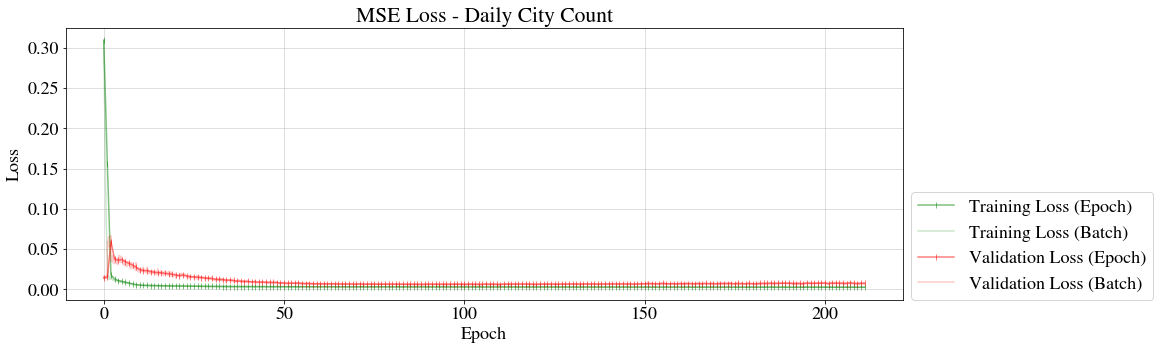

In [278]:
conf.resume = False
conf.checkpoint = "latest" #"latest" # ["best_val", "best_trn", "best_trn_val"]
conf.early_stopping = True
conf.patience = 100
conf.min_epochs = 1
conf.max_epochs = 500

trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_sequence_model,
    loss_fn=criterion,
    conf=conf,
)

In [279]:
logging.info(f"best validation: {np.min(val_epoch_losses):.6f} @ epoch: {np.argmin(val_epoch_losses) + 1}")

2021-01-05T19:26:33 | root | INFO | best validation: 0.005898 @ epoch: 110


In [280]:
from utils.interactive import plot_interactive_epoch_losses
fig = plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)
fig.write_image(f"{save_folder}{FREQ}_loss_val_plot.png")
fig.show()

In [281]:
from trainers.generic_trainer import train_model_final

conf.max_epochs = np.argmin(val_epoch_losses) + 1 # because of index starting at zero

set_system_seed(conf.seed) # should be reset with each model instatiation
model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=output_size,
    num_layers=num_layers,
).to(conf.device)

optimiser = torch.optim.AdamW(params=model.parameters(),lr=conf.lr, weight_decay=conf.weight_decay)

trn_val_epoch_losses = train_model_final(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_sequence_model,
    loss_fn=criterion,
    conf=conf,
)

plot(trn_val_epoch_losses=trn_val_epoch_losses)

2021-01-05T19:27:00 | root | INFO | Set system seed to 1607355910
2021-01-05T19:27:00 | root | INFO | 
 ====================== Final Training Daily City Count ====================== 

2021-01-05T19:27:00 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 128,
 'cap_crime_percentile': 0,
 'checkpoint': 'latest',
 'data_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'log_norm_scale': True,
 'lr': 0.001,
 'max_epochs': 110,
 'min_epochs': 1,
 'model_name': 'Daily City Count',
 'model_path': './data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily '
               'City Count/',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 12,
 'pad_width': 0,
 'patience': 100,
 'resume': False,
 'scale_axis': 1,

2021-01-05T19:27:13 | root | INFO | Epoch: 0055/0110
2021-01-05T19:27:13 | root | INFO | 	Loss (Trn Val): 		0.00258690
2021-01-05T19:27:13 | root | INFO | Epoch: 0056/0110
2021-01-05T19:27:13 | root | INFO | 	Loss (Trn Val): 		0.00258487
2021-01-05T19:27:13 | root | INFO | Epoch: 0057/0110
2021-01-05T19:27:14 | root | INFO | 	Loss (Trn Val): 		0.00258011
2021-01-05T19:27:14 | root | INFO | Epoch: 0058/0110
2021-01-05T19:27:14 | root | INFO | 	Loss (Trn Val): 		0.00257558
2021-01-05T19:27:14 | root | INFO | Epoch: 0059/0110
2021-01-05T19:27:14 | root | INFO | 	Loss (Trn Val): 		0.00256965
2021-01-05T19:27:14 | root | INFO | Epoch: 0060/0110
2021-01-05T19:27:14 | root | INFO | 	Loss (Trn Val): 		0.00256617
2021-01-05T19:27:14 | root | INFO | Epoch: 0061/0110
2021-01-05T19:27:15 | root | INFO | 	Loss (Trn Val): 		0.00256027
2021-01-05T19:27:15 | root | INFO | Epoch: 0062/0110
2021-01-05T19:27:15 | root | INFO | 	Loss (Trn Val): 		0.00255945
2021-01-05T19:27:15 | root | INFO | Epoch: 0063/

#### Training Results

In [282]:
# Load latest or best validation model
# conf.checkpoint = "latest"
# conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"
conf.checkpoint = "final" # train and validation set trained model

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
log.info(f"loading model from {conf.model_path}")
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth", map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2021-01-05T19:27:27 | root | INFO | Loading model from checkpoint (final) for evaluation
2021-01-05T19:27:27 | root | INFO | loading model from ./data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525/models/Daily City Count/


<All keys matched successfully>

In [283]:
if FREQ == '1H':
    step=24
    max_steps=14
elif FREQ == '24H':
    step=7
    max_steps=6
elif FREQ == '168H':
    step=52
    max_steps=3

In [284]:
from sklearn.metrics import mean_absolute_error
class EWM:
    def __init__(self, series=None):
        self.alpha = .9
        self.options = np.arange(0.001,0.999,0.001)
        
        if series is not None:
            self.fit(series)
            
    def __call__(self, series):
        return self.predict(series)
        
    def fit(self, series):
        losses = []
        for alpha in self.options:
            self.alpha = alpha
            pred = self.predict(series)
            loss = mean_absolute_error(series, pred)
            losses.append(loss)
            
        self.alpha = self.options[np.argmin(losses)]
#         print(f"alpha => {self.alpha}")
    
    def predict(self, series):
        series = np.pad(series, (1,0), 'edge')
        
        pred = pd.Series(series).ewm(alpha=self.alpha).mean().values[:-1]
        return pred

In [285]:
from pandas import DataFrame

def compare_time_series_metrics(
    y_true, 
    y_score, 
    t_range,
    feature_names, 
    is_training_set,
    step=24, 
    max_steps=29,
    alpha=0.5, 
    rangeslider_visible=True,
):
    kwargs = dict()

    offset = step * max_steps

    assert len(y_true.shape) == 2
    
    
    model_name_dict = {}
    feature_results = {}
    
    if is_training_set:
        training_str = "(Training Data)"
    else:
        training_str = "(Test Data)"
    
     
    for i, feat_name in enumerate(feature_names):
        kwargs[f"{feat_name}_y_score"] = y_score[offset:, i]
        kwargs[f"{feat_name}_y_true"] = y_true[offset:, i]
        kwargs[f"{feat_name}_y_ha"] = historic_average(y_true[:, i], step=step,
                                                       max_steps=max_steps)[offset - 1:-1]    
        
        ewm = EWM(y_true[:,i])
        kwargs[f"{feat_name}_y_ewm"] = ewm(y_true[:,i])[offset:]
        
        feature_results[feat_name] = {
            "Ground Truth": y_true[offset:, i],
            "GRUFNN": y_score[offset:, i],
            f"HA({step},{max_steps})": historic_average(y_true[:, i],
                                                  step=step,max_steps=max_steps)[offset - 1:-1],
            f"EWM({ewm.alpha:.3f})": ewm(y_true[:,i])[offset:],
        }

        model_name_dict[feat_name] = {
            "y_score": "GRUFNN",
            "y_true": "Ground Truth",
            "y_ha": f"HA({step},{max_steps})",
            "y_ewm": f"EWM({ewm.alpha:.3f})",
        }
        
        fig = plot_time_signals(
            t_range=t_range[offset:], 
            alpha=alpha,
            title=f'{freq_title} {feat_name.title()} Predicted Normalised City Counts {training_str}',
            ylabel='Normalised Counts [0,1]',
            xlabel='Date',
            rangeslider_visible=rangeslider_visible,
            **feature_results[feat_name]
        )

        fig.write_image(f"{save_folder}{FREQ}_{feat_name}_predictions_{training_str}.png")
        fig.show()

    ll = [] # {}
    for k, v in kwargs.items():
        i = k.find("_")
        feat_name = k[:i]
        model_type = k[i+1:]
        if model_type == 'y_true':
            continue
        row = {}
        crime_type_name = feat_name.title()
        model_name = model_name_dict[feat_name][model_type]
        row['Crime Type'] = crime_type_name
        row['Model'] = model_name
        row_ = forecast_metrics(y_true=kwargs[f"{feat_name}_y_true"], y_score=kwargs[k])
        row = {**row, **row_}
        
        ll.append(row)

#     plot_time_signals(t_range=t_range[offset:], alpha=alpha,
#                       title=f'{freq_title} Predicted Normalised City Counts',
#                       yaxis_title='Normalised Counts [0,1]',**kwargs).show()

    metrics = DataFrame(ll)
    metrics.sort_values(['Crime Type','MASE'],inplace=True)
    metrics.reset_index(inplace=True, drop='index')

    return metrics

In [286]:
from utils.utils import write_txt
metrics_folder = f"./data/processed/{data_sub_path}/metrics/"
os.makedirs(metrics_folder, exist_ok=True)

In [287]:
trn_y_true, trn_y_score = evaluate_sequence_model(model, loaders.train_loader, conf)

# trn_y_score = scaler.inverse_transform(trn_y_score)
# trn_y_true = scaler.inverse_transform(trn_y_true)

trn_metrics = compare_time_series_metrics(
    y_true=trn_y_true,
    y_score=trn_y_score,
    t_range=loaders.train_loader.dataset.t_range[-len(trn_y_true):],
    feature_names=list(total_df.columns[:trn_y_true.shape[1]]),#feature_names[:trn_y_true.shape[1]],
    step=step,
    max_steps=max_steps,
    is_training_set=True,
    rangeslider_visible=False,
)
display(trn_metrics)

trn_metrics_latex = trn_metrics.round(decimals=3).to_latex(
    index=False,
    caption=f"{freq_title} Crime Count Forecasting Metrics (Training Data)",
    label="tab:daily-crime-count-metrics",
)

pd.to_pickle(trn_metrics, f"{metrics_folder}{FREQ}_metrics_train.pkl")
write_txt(trn_metrics_latex, f"{metrics_folder}{FREQ}_metrics_train_latex.txt")

Crime Type       Model      MASE       MAE       MSE      RMSE
0      Total      GRUFNN  0.703868  0.039470  0.002767  0.052598
1      Total  EWM(0.165)  0.863899  0.048459  0.004098  0.064014
2      Total     HA(7,6)  0.963279  0.054018  0.005159  0.071823

#### Best Test Results (1H)  `(best 0.700818)`
```python
hidden_size = 20
epochs = 4
seq_len = 168
batch_size = 128
lr = 1-e2
seed = 1606470692
num_layer=1


GRUFNN(
  (gru): GRU(18, 20, batch_first=True)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (activation): RReLU(lower=0.01, upper=0.1)
)

model = GRUFNN(
    input_size=input_size,
    hidden_size0=hidden_size, 
    hidden_size1=hidden_size//2, 
    output_size=1, 
    num_layers=2,
)
```

#### Best Test Results (24H)  `(best 0.814835)`
```python
val_ratio = 0.25
tst_ratio = 0.25
hidden_size = 100
epochs = 15
seq_len = 90
batch_size = 128
lr = 1-e2
seed = 1607355910
num_layer=2

GRUFNN(
  (gru): GRU(16, 100, num_layers=2, batch_first=True)
  (lin1): Linear(in_features=100, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=1, bias=True)
  (activation): RReLU(lower=0.01, upper=0.1)
)
```



In [288]:
tst_y_true, tst_y_score = evaluate_sequence_model(model, loaders.test_loader, conf)
# tst_y_true, tst_y_score = tst_y_true[:,0], tst_y_score[:,0] 

tst_metrics = compare_time_series_metrics(
    y_true=tst_y_true, 
    y_score=tst_y_score,
    t_range=loaders.test_loader.dataset.t_range[-len(tst_y_true):],
#     feature_names=feature_names[:tst_y_true.shape[1]],
    feature_names=list(total_df.columns[:tst_y_true.shape[1]]),
    is_training_set=False,
    step=step,
    max_steps=max_steps,
    rangeslider_visible=False,
)

display(tst_metrics)

tst_metrics_latex = tst_metrics.round(decimals=3).to_latex(
    index=False,
    caption=f"{freq_title} Crime Count Forecasting Metrics (Test Data)",
    label="tab:daily-crime-count-metrics",
)

pd.to_pickle(tst_metrics, f"{metrics_folder}{FREQ}_metrics_test.pkl")
write_txt(tst_metrics_latex, f"{metrics_folder}{FREQ}_metrics_test.txt")

Crime Type       Model      MASE       MAE       MSE      RMSE
0      Total      GRUFNN  0.880144  0.027685  0.001247  0.035309
1      Total  EWM(0.341)  0.911698  0.028654  0.001316  0.036275
2      Total     HA(7,6)  1.041704  0.032737  0.001807  0.042505

### 100 nodes @ 2 layers

<html>
<center> <h4>Seed Test Metrics (seed: 232323)</h4> </center>   
    
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>1.036609</td>
      <td>0.032579</td>
      <td>0.001614</td>
      <td>0.040180</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

</html>

<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 15)</h4> </center>   
   

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.892761</td>
      <td>0.028061</td>
      <td>0.001242</td>
      <td>0.035237</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
    
</html>
    
    

<html>
<center> <h4>Seed Test Metrics (seed: 1609862642, epochs: 25)</h4> </center>   
 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.996154</td>
      <td>0.031305</td>
      <td>0.001518</td>
      <td>0.038966</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

  

### 8 nodes @ 2 layers

<html>
<center> <h4>Seed Test Metrics (seed: 1609863699, epochs: 60)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.930785</td>
      <td>0.029265</td>
      <td>0.001306</td>
      <td>0.036135</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 44)</h4> </center>   
 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.868942</td>
      <td>0.027309</td>
      <td>0.001180</td>
      <td>0.034354</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1609863699, epochs: 30)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.918288</td>
      <td>0.028870</td>
      <td>0.001323</td>
      <td>0.036370</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


### 8 nodes @ 1 layer

<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 106)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.916288</td>
      <td>0.028808</td>
      <td>0.001348</td>
      <td>0.036717</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>



<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 17)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.952805</td>
      <td>0.029954</td>
      <td>0.001456</td>
      <td>0.038160</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


<html>
<center> <h4>Seed Test Metrics (seed: 1609864074, epochs: 50)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.917947</td>
      <td>0.028868</td>
      <td>0.001355</td>
      <td>0.036804</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


### 16 nodes @ 2 layer


<html>
<center> <h4>Seed Test Metrics (seed: 1607355910, epochs: 110)</h4> </center>   
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.880144</td>
      <td>0.027685</td>
      <td>0.001247</td>
      <td>0.035309</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>
</html>


In [289]:
from pandas.io import clipboard
clipboard.copy(f'''
<html>
<center> <h4>Seed Test Metrics (seed: {conf.seed}, epochs: {conf.max_epochs})</h4> </center>   
{tst_metrics.to_html()}
</html>
''')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Crime Type</th>
      <th>Model</th>
      <th>MASE</th>
      <th>MAE</th>
      <th>MSE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Total</td>
      <td>EWM(0.341)</td>
      <td>0.911698</td>
      <td>0.028654</td>
      <td>0.001316</td>
      <td>0.036275</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Total</td>
      <td>GRUFNN</td>
      <td>0.996154</td>
      <td>0.031305</td>
      <td>0.001518</td>
      <td>0.038966</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Total</td>
      <td>HA(7,6)</td>
      <td>1.041704</td>
      <td>0.032737</td>
      <td>0.001807</td>
      <td>0.042505</td>
    </tr>
  </tbody>
</table>

In [86]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())
else:
    raise Exception("CUDA is not available")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2032 KB |   83109 KB |    3977 GB |    3977 GB |
|       from large pool |       0 KB |   78762 KB |    3642 GB |    3642 GB |
|       from small pool |    2032 KB |    5951 KB |     335 GB |     335 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2032 KB |   83109 KB |    3977 GB |    3977 GB |
|       from large pool |       0 KB |   78762 KB |    3642 GB |

## Residual Sequence Model

In [ ]:
# time series normalisation 
